In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import matplotlib.patches as mpatches


import cv2

In [ ]:
import os
import pathlib
import sklearn
import pandas as pd
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
from tqdm.autonotebook import tqdm
from timeit import default_timer as timer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torchvision
# from torch import nn
import torch.nn as nn
from torchinfo import summary # Use torchinfo for better model summary
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms
from torchview import draw_graph
from torch.utils.mobile_optimizer import optimize_for_mobile

In [135]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# Data

## Download Dataset Local

In [96]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("roshan81/ageutk")

# print("Path to dataset files:", path)

# /Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6

## Load in Data

In [97]:
# Put your own path here + the csv file
ageutk_path = "/Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6"

ageutk_path_csv = ageutk_path + "/ageutk_full.csv"
ageutk_data = pd.read_csv(ageutk_path_csv)
ageutk_data.head()

files  age  gender
0  26_0_2_20170104023102422.jpg.chip.jpg   26       0
1  22_1_1_20170112233644761.jpg.chip.jpg   22       1
2  21_1_3_20170105003215901.jpg.chip.jpg   21       1
3  28_0_0_20170117180555824.jpg.chip.jpg   28       0
4  17_1_4_20170103222931966.jpg.chip.jpg   17       1

In [98]:
def add_path_to_files(df, path):
    df['path'] = df['files'].apply(lambda x: os.path.join(path+"/UTKFace/UTKFace/UTKFace/", x))
    df = df[['path', 'age', 'gender']]
    return df

ageutk_data = add_path_to_files(df=ageutk_data, path=ageutk_path)
ageutk_data.head()

path  age  gender
0  /Users/hidde/.cache/kagglehub/datasets/roshan8...   26       0
1  /Users/hidde/.cache/kagglehub/datasets/roshan8...   22       1
2  /Users/hidde/.cache/kagglehub/datasets/roshan8...   21       1
3  /Users/hidde/.cache/kagglehub/datasets/roshan8...   28       0
4  /Users/hidde/.cache/kagglehub/datasets/roshan8...   17       1

### Preview Data

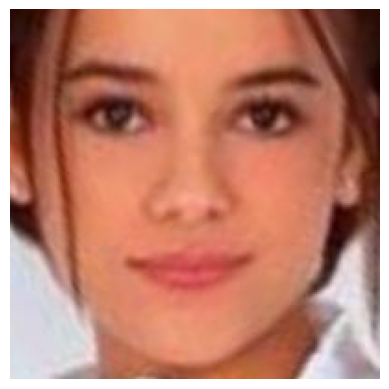

In [99]:
i = 10
ageutk_path_example = ageutk_data['path'][i]
# ageutk_path_example = '/Users/hidde/.cache/kagglehub/datasets/roshan81/ageutk/versions/6/UTKFace/UTKFace/UTKFace/' + ageutk_data["files"][i]
image = cv2.imread(ageutk_path_example)
# plt.imshow(image)

# Converteer de afbeelding van BGR naar RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Toon de afbeelding met matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Verberg de assen
plt.show()


### 

In [100]:
print(f"Min age: {ageutk_data['age'].min()}, Max age: {ageutk_data['age'].max()}")
print(ageutk_data['age'].dtype)
ageutk_data.loc[ageutk_data['age'] > 70, 'age'] = 70

Min age: 1, Max age: 80
int64


### Create Class Labels for age

In [101]:
# age_bins = [0, 12, 18, 25, 55, 70]
# age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']

age_bins = [0, 18, 25, 70]
age_labels = ['Not Old Enough', 'Check ID', 'Old Enough']

ageutk_data['age'] = pd.cut(
    ageutk_data['age'], bins=age_bins, 
    labels=age_labels, right=True
)

age_idx = {label:i for i, label in enumerate(age_labels)}
print(age_idx)
ageutk_data

{'Not Old Enough': 0, 'Check ID': 1, 'Old Enough': 2}


path             age  \
0      /Users/hidde/.cache/kagglehub/datasets/roshan8...      Old Enough   
1      /Users/hidde/.cache/kagglehub/datasets/roshan8...        Check ID   
2      /Users/hidde/.cache/kagglehub/datasets/roshan8...        Check ID   
3      /Users/hidde/.cache/kagglehub/datasets/roshan8...      Old Enough   
4      /Users/hidde/.cache/kagglehub/datasets/roshan8...  Not Old Enough   
...                                                  ...             ...   
23163  /Users/hidde/.cache/kagglehub/datasets/roshan8...      Old Enough   
23164  /Users/hidde/.cache/kagglehub/datasets/roshan8...      Old Enough   
23165  /Users/hidde/.cache/kagglehub/datasets/roshan8...  Not Old Enough   
23166  /Users/hidde/.cache/kagglehub/datasets/roshan8...      Old Enough   
23167  /Users/hidde/.cache/kagglehub/datasets/roshan8...      Old Enough   

       gender  
0           0  
1           1  
2           1  
3           0  
4           1  
...       ...  
23163       0  
23164       0  
23165       0  
23166       1  
23167       0  

[23168 rows x 3 columns]

In [103]:
#70, 15, 15
train_ageutk, test_ageutk = train_test_split(ageutk_data, shuffle=True, test_size=0.15) # 15%
train_ageutk, val_ageutk = train_test_split(train_ageutk, shuffle=True, test_size=0.176) # 15/85 = 0.176
display(train_ageutk.head())
print("Shape of Dataset: ", train_ageutk.shape, test_ageutk.shape)

path             age  \
2884   /Users/hidde/.cache/kagglehub/datasets/roshan8...      Old Enough   
99     /Users/hidde/.cache/kagglehub/datasets/roshan8...        Check ID   
4427   /Users/hidde/.cache/kagglehub/datasets/roshan8...      Old Enough   
713    /Users/hidde/.cache/kagglehub/datasets/roshan8...  Not Old Enough   
16159  /Users/hidde/.cache/kagglehub/datasets/roshan8...      Old Enough   

       gender  
2884        0  
99          1  
4427        0  
713         1  
16159       1

Shape of Dataset:  (16226, 3) (3476, 3)


In [104]:
# age_gender = test_ageutk.groupby(['age','gender'], observed=True).first()
# age_gender

In [105]:
# ## Creating a seperate folder for unseen data

# output_dir = "organised_images"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Iterate over the rows in the DataFrame
# for index, row in test_ageutk.iterrows():
#     src_path = row['path']
#     dest_path = os.path.join(output_dir, os.path.basename(src_path))

#     try:
#         shutil.copy(src_path, dest_path)
#     except Exception as e:
#         print("Failed to copy {src_path}: {e}")

### Data Transformation

In [106]:
train_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# custom_transform = transforms.Compose([
#     transforms.Resize(size=(128, 128)),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

ml_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [107]:
def plot_transformed_images(image_dataset: pd.DataFrame, transform, n=3, seed=None):
    """Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version."""
    image_paths = list(image_dataset['path'])
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # Original Image
            ax[0].imshow(f)
            ax[0].set_title(f'Original Image \nSize: {f.size}')
            ax[0].axis(False)

            # Transformed Image
            transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C) for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Image \nSize: {transformed_image.shape}')
            ax[1].axis('off')

            # Here a list comprehension because suptitle trys to find class information
            image_class = [x for x in image_dataset[image_dataset["path"]==image_path]['age']][0]
            fig.suptitle(f'Class: {image_class}', fontsize=14)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..1.8721637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.6291069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


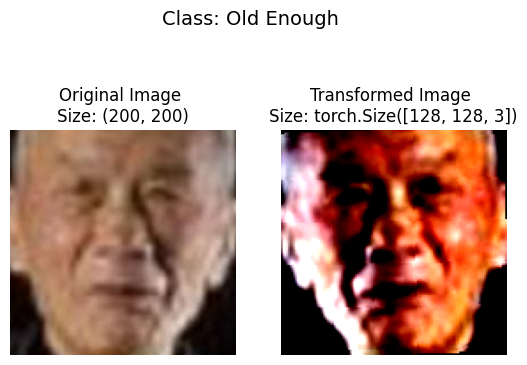

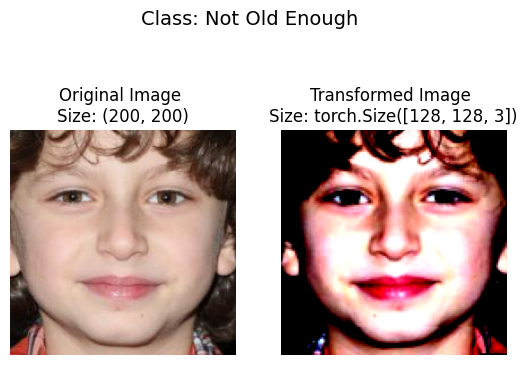

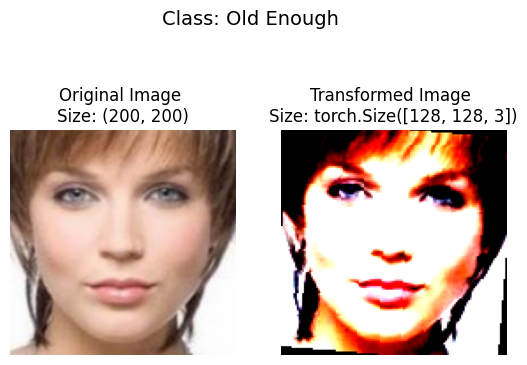

In [ ]:

plot_transformed_images(image_dataset=train_ageutk,
                        transform=train_transform,
                        n=3,
                        seed=None)


# Create Dataset

In [109]:
class Image_Dataset(Dataset):
    def __init__(self, ageutk_data:pd.DataFrame, age_idx:dict, transform=None):
        self.ageutk_df = ageutk_data
        self.transform = transform
        self.age_idx = age_idx

    def __len__(self):
        return len(self.ageutk_df)

    def __getitem__(self, idx):
        row = self.ageutk_df.iloc[idx]
        image = Image.open(row['path'])
        label = [
            self.age_idx[row['age']],
            # row['gender'],
            # -1
        ]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label)


# import torch
# import numpy as np
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset

# class Image_Dataset(Dataset):
#     def __init__(self, ageutk_data: pd.DataFrame, age_idx: dict, transform=None, flatten=False):
#         """
#         Args:
#             ageutk_data (pd.DataFrame): DataFrame met afbeeldingspaden en labels.
#             age_idx (dict): Mapping van leeftijd naar indices.
#             transform (callable, optional): Transformatie voor afbeeldingen.
#             flatten (bool): Als True, retourneer 1D-vector voor RandomForest; anders 3D-tensor voor CNN's.
#         """
#         self.ageutk_df = ageutk_data
#         self.transform = transform
#         self.age_idx = age_idx
#         self.flatten = flatten  # Nieuw: Bepaalt of we 1D-vector of 3D-tensor teruggeven

#     def __len__(self):
#         return len(self.ageutk_df)

#     def __getitem__(self, idx):
#         row = self.ageutk_df.iloc[idx]
#         image = Image.open(row['path']).convert("RGB")  # Zorg dat het RGB is
#         label = [
#             self.age_idx[row['age']],
#             row['gender']
#         ]
        
#         if self.transform:
#             image = self.transform(image)
        
#         if self.flatten:
#             image = image.view(-1).numpy()  # Zet tensor om naar 1D NumPy-array voor RandomForest
#         else:
#             image = image  # Houd het als een 3D-tensor voor CNN's

#         return image, torch.tensor(label)


In [110]:
train_dataset_NN = Image_Dataset(ageutk_data=train_ageutk,
                                    transform=train_transform, age_idx=age_idx)

val_dataset_NN = Image_Dataset(ageutk_data=val_ageutk,
                                    transform=test_transform, age_idx=age_idx)

test_dataset_NN = Image_Dataset(ageutk_data=test_ageutk, age_idx=age_idx, 
                                    transform=test_transform)


train_dataloader_NN = DataLoader(train_dataset_NN, batch_size=16, 
                                       shuffle=True, num_workers=0) #num_workers=os.cpu_count())

val_dataloader_NN = DataLoader(val_dataset_NN, batch_size=16,
                                     shuffle=True, num_workers=0) #num_workers=os.cpu_count())

test_dataloader_NN = DataLoader(test_dataset_NN, batch_size=16, 
                                      shuffle=True, num_workers=0) #num_workers=os.cpu_count())

In [111]:
# 2 Functie om DataLoader naar NumPy om te zetten
def dataloader_to_numpy(dataloader):
    X_list, y_list = [], []
    
    for X_batch, y_batch in dataloader:
        X_list.append(X_batch.view(X_batch.size(0), -1).numpy())  # 1D vector
        y_list.append(y_batch.numpy()[:, 0])  # Alleen leeftijd gebruiken
    
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    return X, y

# 3️ Converteer data voor RandomForest
X_train, y_train = dataloader_to_numpy(train_dataloader_NN)
X_val, y_val = dataloader_to_numpy(val_dataloader_NN)
X_test, y_test = dataloader_to_numpy(test_dataloader_NN)


In [112]:
# # Function to convert image paths to 1D numpy arrays
# def images_to_numpy(image_paths, transform=None):
#     images = []
#     for path in image_paths:
#         image = Image.open(path).convert("RGB")
#         image = np.array(image)
#         image = image.flatten()
#         # image = transform(image)
#         # image = image.view(-1).numpy()  # Flatten the image to 1D
#         images.append(image)
#     return np.array(images)

# # Convert train, validation, and test images to numpy arrays
# X_train = images_to_numpy(train_ageutk['path'])#, custom_transform)
# X_val = images_to_numpy(val_ageutk['path'])#, custom_transform)
# X_test = images_to_numpy(test_ageutk['path'])#, custom_transform)

# # Extract labels
# y_train = np.array([age_idx[age] for age in train_ageutk['age']])
# y_val = np.array([age_idx[age] for age in val_ageutk['age']])
# y_test = np.array([age_idx[age] for age in test_ageutk['age']])


# ML Modelling

In [113]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import confusion_matrix, accuracy_score

# def test_rfc(X_train, y_train, X_val, y_val):
#     # Definieer het Random Forest model
#     model_rfc = RandomForestClassifier()
    
#     # Hyperparameter grid voor tuning
#     parameters_rfc = {
#         'min_samples_split': [2, 5, 10, 20],
#         'min_samples_leaf': [2, 4, 6, 8, 10],
#         'min_weight_fraction_leaf': [0.01, 0.05, 0.1]
#     }
    
#     # Grid Search uitvoeren
#     # Grid_rfc = GridSearchCV(model_rfc, parameters_rfc, cv=3, n_iter=10, n_jobs=-1)
#     Grid_rfc = RandomizedSearchCV(model_rfc, parameters_rfc, cv=3, n_iter=10, n_jobs=-1)
#     Grid_rfc.fit(X_train, y_train)
#     y_pred = Grid_rfc.predict(X_val)
    
#     # Resultaten tonen
#     print("\nRandom Forest Classifier")
#     print("Tuned RFC Parameters:", Grid_rfc.best_params_)
#     print("Best score:", Grid_rfc.best_score_)
#     print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
#     print("Accuracy Score:", accuracy_score(y_val, y_pred))
#     print("Classification Report:\n", classification_report(y_val, y_pred))
#     print("Score:", Grid_rfc.score(X_val, y_val))
#     print("====================================================================")

#     return Grid_rfc.best_params_

# # Voorbeeld aanroep (data moet beschikbaar zijn in de juiste variabelen)
# best_params_rfc = test_rfc(X_train, y_train, X_val, y_val)
# print("\nBeste parameters voor RFC:", best_params_rfc)


In [114]:
# # Train a RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=100, random_state=55)
# clf.fit(X_train, y_train)

# # Validate model
# y_pred_val = clf.predict(X_val)
# val_accuracy = accuracy_score(y_val, y_pred_val)
# print(f"Validation Accuracy: {val_accuracy:.2f}")

# # Test model
# y_pred_test = clf.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_pred_test)
# print(f"Test Accuracy: {test_accuracy:.2f}")

# CNN Modelling

In [115]:
train_images, train_labels = next(iter(train_dataloader_NN))
train_images.shape, train_labels.shape, train_labels[:5]

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 1]),
 tensor([[0],
         [2],
         [2],
         [2],
         [1]]))

In [116]:
val_images, val_labels = next(iter(val_dataloader_NN))
val_images.shape, val_labels.shape, val_labels[:5]

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 1]),
 tensor([[2],
         [0],
         [2],
         [2],
         [0]]))

In [117]:
# Visualize images with their labels
def visualize_batch(images, labels):
    """
    Visualizes a batch of images in an 4x4 grid.
    
    Parameters:
        images (torch.Tensor): Batch of images (B, C, H, W).
        labels (list): Corresponding labels [[age_idx, gender_idx, emotion_idx], ...].
    """
    # Define the grid size
    rows, cols = 4, 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 20))
    
    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            ax.axis('off')
            continue
        
        image = images[i]
        
        # Display the image
        ax.imshow(image.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
        # ax.set_title(f"Age Id: {labels[i][0]}\nGender Id: {labels[i][1]}")
        ax.set_title(f"Age Id: {labels[i][0]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.169412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..1.9558823].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.923538].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..2.4482791].

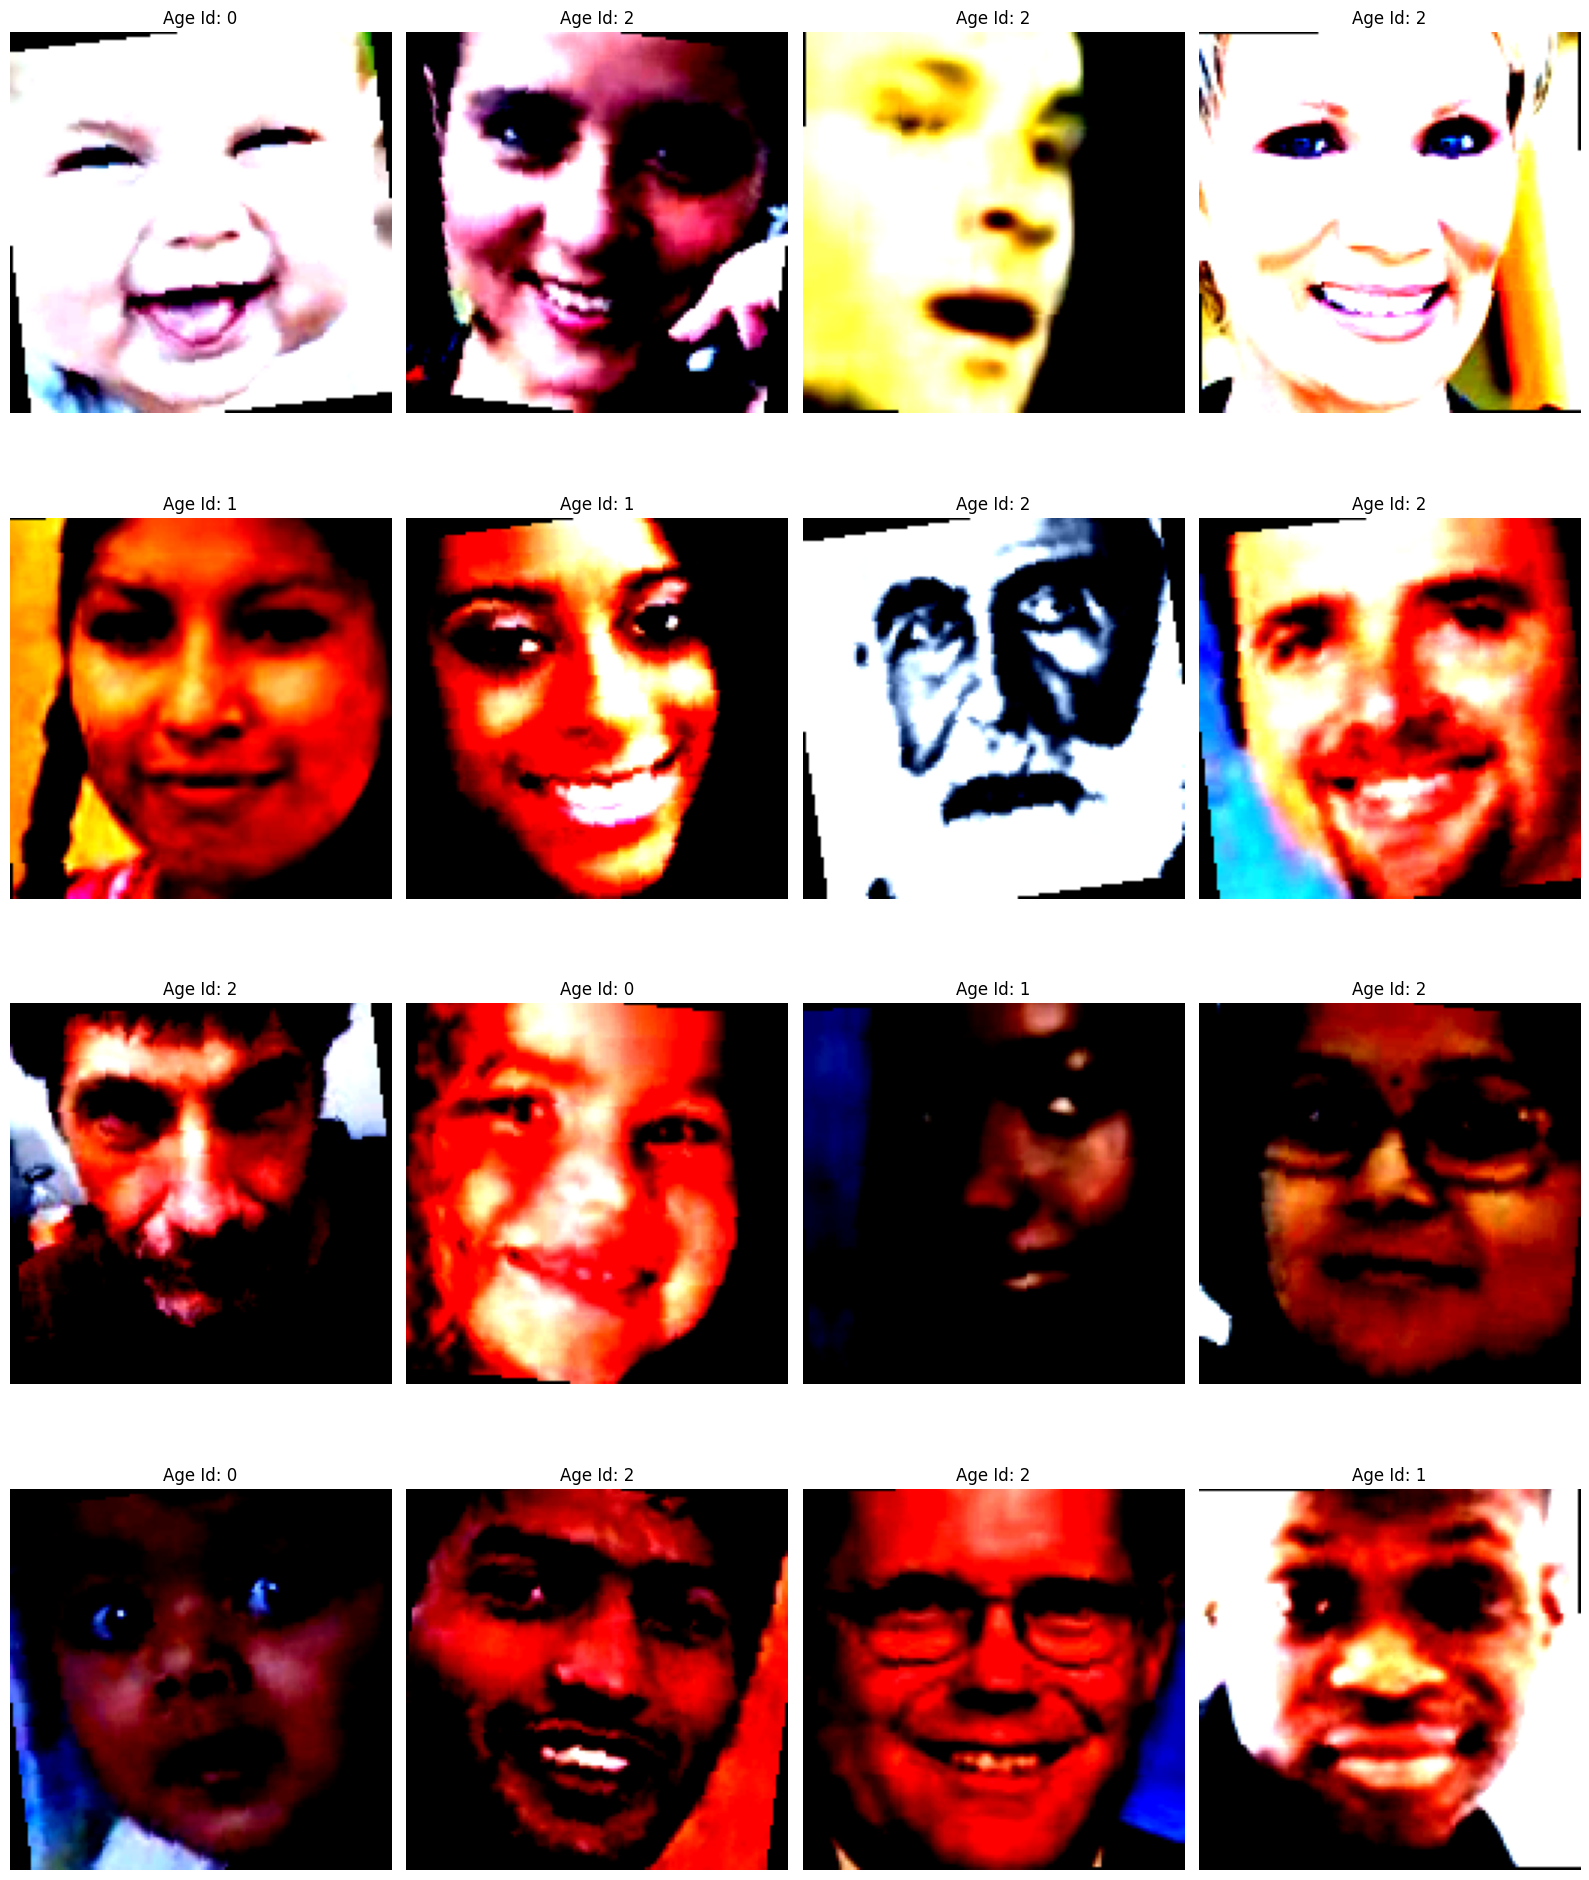

In [118]:
visualize_batch(train_images, train_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.0434113].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5805322..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4754901..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.248

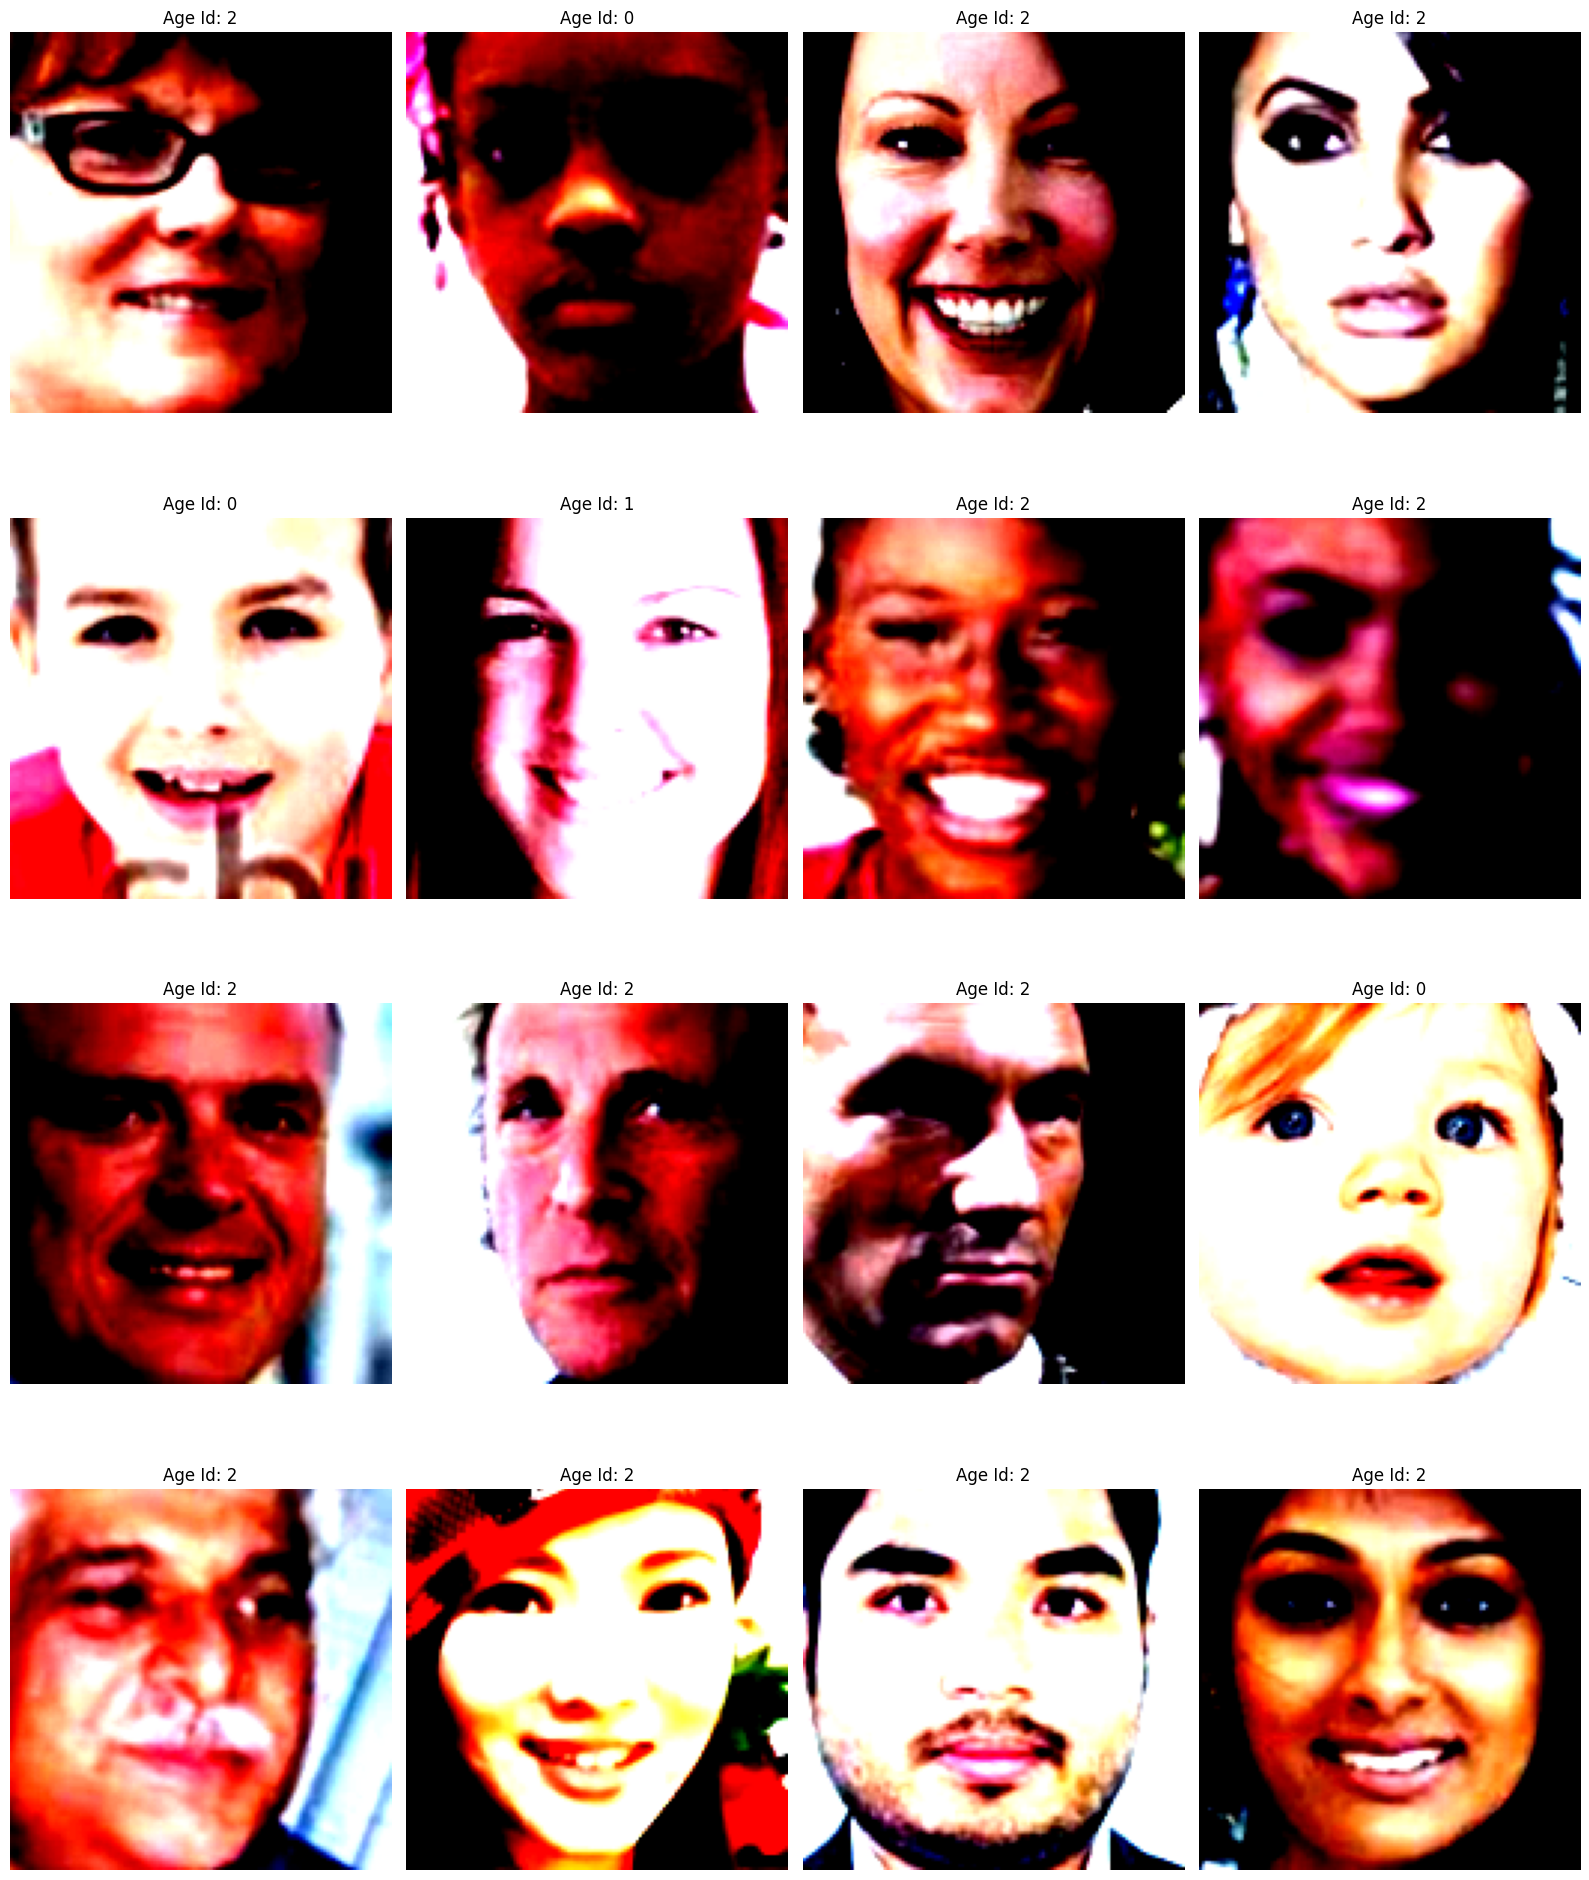

In [119]:
visualize_batch(val_images, val_labels)

In [120]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class AgePredictionCNN(nn.Module):
#     def __init__(self, num_age_bins=3):
#         super().__init__()

#         # Convolutional layers
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
        
#         # Pooling
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Fully connected layers
#         self.fc1 = nn.Linear(128 * 32 * 32, 256)  # images are rescaled to 128x128
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(256, 128)
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(128, num_age_bins)

#     def forward(self, x):
#         # Convolution layers with activation and Pooling
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))

#         # Flatten for fully connected layers
#         x = x.view(x.shape[0], -1)  # Flatten to 1D vector

#         # Fully connected layers with dropout and activation
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)

#         # Outputlaag (geen softmax nodig bij CrossEntropyLoss)
#         x = self.fc3(x)
#         return x  # Output zijn logits (geen softmax hier)



In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AgePredictionCNN(nn.Module):
    def __init__(self, num_age_bins=3, input_size=128):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Corrected fully connected input size
        fc_input_dim = 128 * 16 * 16  # Correct size after conv+pooling

        # Fully connected layers
        self.fc1 = nn.Linear(fc_input_dim, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, num_age_bins)

    def forward(self, x):
        # Convolution layers with activation and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten for fully connected layers
        x = x.view(x.shape[0], -1)  # Correct flattening

        # Fully connected layers with dropout and activation
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        # Output layer (no softmax needed with CrossEntropyLoss)
        x = self.fc3(x)
        return x  # Output logits


In [ ]:
def train_step(model, dataloader, age_loss_fn, optimizer, device=device):
    """
    Perform a single training step for one epoch (Age Classification Only).

    Parameters:
        model: PyTorch CNN model (only for age classification).
        dataloader: DataLoader for training data.
        age_loss_fn: Loss function for age classification.
        optimizer: Optimizer to update the model parameters.
        device: Device for computation (e.g., "cpu" or "cuda").

    Returns:
        train_loss: Average loss over the epoch.
        train_acc: Average age classification accuracy.
    """
    model.train()
    train_loss = 0
    total_age_accuracy = 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        X, y = X.to(device), y[:, 0].long().to(device)  # Use only age labels

        # Forward Pass
        age_pred = model(X)

        # Compute Age Loss
        age_loss = age_loss_fn(age_pred, y)

        # Compute Accuracy
        age_pred_class = age_pred.argmax(dim=1)  # Get predicted classes
        age_accuracy = (age_pred_class == y).sum().item() / y.size(0)
        total_age_accuracy += age_accuracy

        # Backpropagation
        optimizer.zero_grad()
        age_loss.backward()
        optimizer.step()

        # Accumulate Loss
        train_loss += age_loss.item()

    # Compute Average Loss and Accuracy
    train_loss /= num_batches
    avg_age_accuracy = total_age_accuracy / num_batches

    return train_loss, avg_age_accuracy


In [ ]:
def test_step(model, dataloader, age_loss_fn, device=device):
    """
    Perform a single testing step for Age Classification Only.

    Parameters:
        model: PyTorch CNN model (only for age classification).
        dataloader: DataLoader for test data.
        age_loss_fn: Loss function for age classification.
        device: Device for computation (e.g., "cpu" or "cuda").

    Returns:
        test_loss: Average loss over the epoch.
        test_acc: Average accuracy for age classification.
    """
    model.eval()
    test_loss = 0
    total_age_accuracy = 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y[:, 0].long().to(device)  # Use only age labels

            # Forward Pass
            age_pred = model(X)

            # Compute Age Loss
            age_loss = age_loss_fn(age_pred, y)

            # Compute Accuracy
            age_pred_class = age_pred.argmax(dim=1)  # Get predicted classes
            age_accuracy = (age_pred_class == y).sum().item() / y.size(0)
            total_age_accuracy += age_accuracy

            # Accumulate Total Loss
            test_loss += age_loss.item()

    # Compute Average Loss and Accuracy
    test_loss /= num_batches
    avg_age_accuracy = total_age_accuracy / num_batches

    return test_loss, avg_age_accuracy


In [ ]:
def train(model, 
          train_dataloader, 
          test_dataloader, 
          optimizer, 
          age_loss_fn, 
          epochs, 
          device=device):
    """
    Training loop for Age Classification Only.

    Parameters:
        model: PyTorch CNN model (only for age classification).
        train_dataloader: DataLoader for training data.
        test_dataloader: DataLoader for testing data.
        optimizer: Optimizer for the model.
        age_loss_fn: Loss function for age classification.
        epochs: Number of epochs to train the model.
        device: Device for computation (e.g., "cuda" or "cpu").

    Returns:
        results: Dictionary containing training and testing losses and accuracies.
    """
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(epochs):

        # Training Step
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            age_loss_fn=age_loss_fn,
            optimizer=optimizer,
            device=device
        )

        # Testing Step
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            age_loss_fn=age_loss_fn,
            device=device
        )

        # Logging
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4%}")
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4%}")

        # Append Results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results


In [125]:
EPOCHS = 5
NUM_AGE_BINS = len(age_idx)  # Should be 3: {'Not Old Enough': 0, 'Check ID': 1, 'Old Enough': 2}

In [126]:
# Initialize model (only for age classification)
CNN_model = AgePredictionCNN(num_age_bins=NUM_AGE_BINS, input_size=128).to("cpu")

# Define optimizer and loss function
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)
# age_loss_fn = nn.CrossEntropyLoss()
# class_weights = torch.tensor([1.5, 2.0, 0.5]).to("cpu")  # Geef meer gewicht aan underrepresented classes
# Class weights (in volgorde: [0-18, 18-25, >25])
class_weights = torch.tensor([5.15, 7.37, 1.49]).to("cpu")
age_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Print model summary
summary(CNN_model, input_size=(1, 3, 128, 128))  # Batch size 1, 3 color channels, 128x128 image


Layer (type:depth-idx)                   Output Shape              Param #
AgePredictionCNN                         [1, 3]                    --
├─Conv2d: 1-1                            [1, 32, 128, 128]         896
├─BatchNorm2d: 1-2                       [1, 32, 128, 128]         64
├─MaxPool2d: 1-3                         [1, 32, 64, 64]           --
├─Conv2d: 1-4                            [1, 64, 64, 64]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 64, 64]           128
├─MaxPool2d: 1-6                         [1, 64, 32, 32]           --
├─Conv2d: 1-7                            [1, 128, 32, 32]          73,856
├─BatchNorm2d: 1-8                       [1, 128, 32, 32]          256
├─MaxPool2d: 1-9                         [1, 128, 16, 16]          --
├─Linear: 1-10                           [1, 256]                  8,388,864
├─Dropout: 1-11                          [1, 256]                  --
├─Linear: 1-12                           [1, 128]                  

In [127]:
# from torchviz import make_dot

# # Instantiate the model for age classification
# model = AgePredictionCNN(num_age_bins=len(age_idx), input_size=128).to("cpu")

# # Create a dummy input tensor (1 sample, 3 color channels, 128x128 resolution)
# dummy_input = torch.randn(1, 3, 128, 128).to("cpu")

# # Perform a forward pass and visualize the computation graph
# output = model(dummy_input)
# model_graph = make_dot(output, params=dict(model.named_parameters()))

# # Show the graph
# model_graph.render("AgePredictionCNN_Graph", format="png", cleanup=True)  # Save as PNG
# model_graph


In [ ]:
%%time
from timeit import default_timer as timer

# Start timing
start_time = timer()

# Train the model (only for age classification)
model_results = train(
    model=CNN_model,  # Use AgePredictionCNN
    train_dataloader=train_dataloader_NN,  # Only Age dataset
    test_dataloader=val_dataloader_NN,  # Only Age dataset
    optimizer=optimizer,
    age_loss_fn=age_loss_fn,  # Only Age loss
    epochs=EPOCHS,
    device=device
)

# End timing
end_time = timer()
print(f'Total Training Time: {end_time - start_time:.3f} seconds')



Epoch 1/5
Train Loss: 1.1858 | Train Acc: 54.4335%
Test Loss: 0.9204 | Test Acc: 71.9355%

Epoch 2/5
Train Loss: 0.9627 | Train Acc: 70.5727%
Test Loss: 0.8701 | Test Acc: 75.8468%

Epoch 3/5
Train Loss: 0.9125 | Train Acc: 72.4569%
Test Loss: 0.8261 | Test Acc: 76.8664%

Epoch 4/5
Train Loss: 0.8773 | Train Acc: 69.4520%
Test Loss: 0.8357 | Test Acc: 67.0968%

Epoch 5/5
Train Loss: 0.8531 | Train Acc: 73.3067%
Test Loss: 0.8031 | Test Acc: 77.2005%
Total Training Time: 784.512 seconds
CPU times: user 1h 44min 7s, sys: 25min 8s, total: 2h 9min 16s
Wall time: 16min 16s


In [ ]:
def plot_loss_and_accuracy_curves(results: Dict[str, List[float]]):
    """Plots training and testing loss and accuracy curves for Age Classification."""
    
    # Extract losses
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Extract Age Accuracy
    train_acc = results['train_acc']
    test_acc = results['test_acc']

    epochs = range(len(train_loss))

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Age Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Age Accuracy')
    plt.plot(epochs, test_acc, label='Test Age Accuracy')
    plt.title('Age Classification Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('age_classification_results.png')
    plt.show()


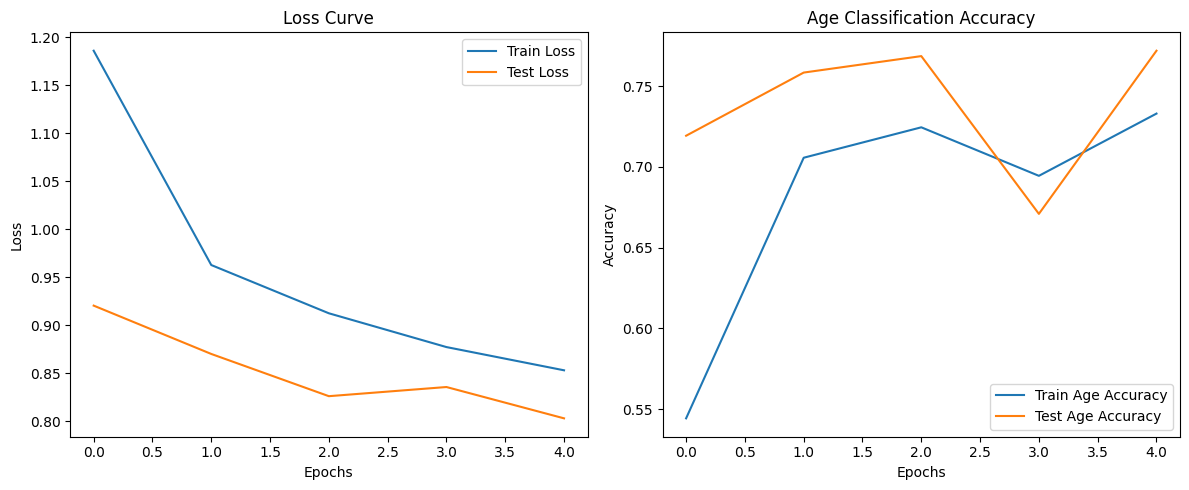

In [130]:
plot_loss_and_accuracy_curves(model_results)

# Model Evaluation

In [ ]:
def predict(model, dataloader, device=device):
    """
    Perform prediction for Age Classification Only.

    Parameters:
        model: PyTorch CNN model (only for age classification).
        dataloader: DataLoader for test data.
        device: Device for computation (e.g., "cpu" or "cuda").

    Returns:
        results: Dictionary containing predicted and true age classes.
    """
    age_pred_classes, age_true_classes = [], []

    model.eval()

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y[:, 0].to(device)

            # Forward pass
            age_pred = model(X)

            # Get predicted class
            age_pred_class = age_pred.argmax(dim=1).tolist()
            age_true_class = y.tolist()
            
            # Store results
            age_pred_classes.extend(age_pred_class)
            age_true_classes.extend(age_true_class)

    # Return results
    results = {
        "Age": {'pred': age_pred_classes, 'true': age_true_classes}
    }
    
    return results


In [132]:
eval_results = predict(model=CNN_model, dataloader=test_dataloader_NN)

In [133]:
from sklearn.metrics import classification_report

# Extract valid indices (if -1 is used as a missing value indicator)
valid_age_indices = [i for i, value in enumerate(eval_results['Age']['true']) if value != -1]

# Filter out valid predictions and true labels
valid_true_ages = [eval_results['Age']['true'][i] for i in valid_age_indices]
valid_pred_ages = [eval_results['Age']['pred'][i] for i in valid_age_indices]

# Ensure target names match age bins
age_names = list(age_idx.keys())  # Extract names from age_idx dictionary

# Print classification report
print(classification_report(y_true=valid_true_ages, y_pred=valid_pred_ages, target_names=age_names))


                precision    recall  f1-score   support

Not Old Enough       0.80      0.73      0.76       677
      Check ID       0.19      0.04      0.07       461
    Old Enough       0.79      0.94      0.86      2338

      accuracy                           0.78      3476
     macro avg       0.59      0.57      0.56      3476
  weighted avg       0.71      0.78      0.74      3476



In [134]:
from collections import Counter

train_labels = [label[0] for _, label in train_dataloader_NN]  # Pak alleen leeftijd labels
print(Counter(train_labels))


Counter({tensor([2]): 1, tensor([0]): 1, tensor([2]): 1, tensor([0]): 1, tensor([2]): 1, tensor([2]): 1, tensor([2]): 1, tensor([2]): 1, tensor([1]): 1, tensor([2]): 1, tensor([2]): 1, tensor([1]): 1, tensor([0]): 1, tensor([2]): 1, tensor([0]): 1, tensor([2]): 1, tensor([1]): 1, tensor([1]): 1, tensor([2]): 1, tensor([2]): 1, tensor([1]): 1, tensor([2]): 1, tensor([2]): 1, tensor([2]): 1, tensor([2]): 1, tensor([0]): 1, tensor([2]): 1, tensor([2]): 1, tensor([1]): 1, tensor([2]): 1, tensor([1]): 1, tensor([2]): 1, tensor([2]): 1, tensor([1]): 1, tensor([2]): 1, tensor([0]): 1, tensor([0]): 1, tensor([2]): 1, tensor([2]): 1, tensor([1]): 1, tensor([2]): 1, tensor([2]): 1, tensor([2]): 1, tensor([2]): 1, tensor([0]): 1, tensor([2]): 1, tensor([0]): 1, tensor([0]): 1, tensor([2]): 1, tensor([1]): 1, tensor([2]): 1, tensor([1]): 1, tensor([2]): 1, tensor([2]): 1, tensor([2]): 1, tensor([1]): 1, tensor([2]): 1, tensor([2]): 1, tensor([2]): 1, tensor([2]): 1, tensor([1]): 1, tensor([1]): 1,